In [1]:
import sys, os

sys.path.append("..")
from common_utils import DATA_HOME
from lstm.sales_data import Sales_Dataset
from torch.utils.data.dataloader import DataLoader
import torch

In [2]:
SALE_HOME = os.path.join(DATA_HOME, "sales_data")

I, H, B = 72, 72, 6
HEAD = 6

sd = Sales_Dataset(SALE_HOME, seq_len=500)
test_set, train_set = torch.utils.data.random_split(sd, [0.1, 0.9])
train_dl = DataLoader(train_set, shuffle=True, batch_size=B)
test_dl = DataLoader(test_set, shuffle=True, batch_size=B)

/home/anyxling/SOTA/lstm/../lstm/sales_data.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.TR.loc[


In [3]:
print(len(train_dl), len(test_dl))
# print(sd.O.describe())
# print(sd.TS.describe())
# print(sd.S.describe())
print(sd[0][0].shape, sd[4][0].shape)
# print(sd[4][1].shape)
# print(sd[4][0], sd[4][1])

9623 1070
torch.Size([500, 72]) torch.Size([500, 72])


In [5]:
checkpoint = torch.load('sales_model_4500.pth')
print(checkpoint.keys()) 

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'])


### PyTorch Model training

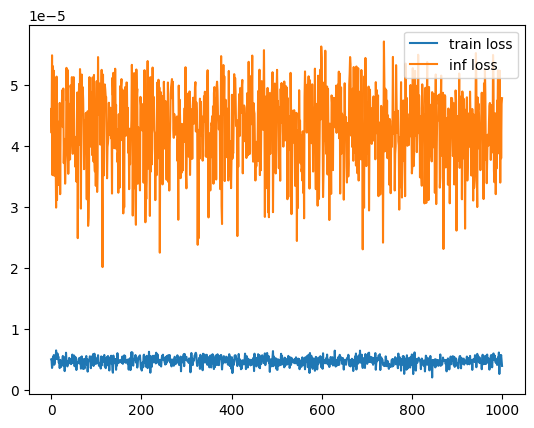

iteration: 5500 train loss: 3.9761974845496955e-06 inf loss: 4.791571784799344e-05


KeyboardInterrupt: 

In [7]:
from torch.nn import LSTM
from torch.nn import MSELoss
from torch import optim
import matplotlib.pyplot as plt
from IPython.display import clear_output

resume_from = 'sales_model_4500.pth'
iteration = int(resume_from.split('_')[-1].split('.')[0])
model = LSTM(I, H, batch_first=True).cuda()
checkpoint = torch.load(resume_from)
model.load_state_dict(torch.load(resume_from))
loss = MSELoss()
adam = optim.Adam(model.parameters(), lr=0.001)
tr_losses, inf_losses = [], []

train_gen = enumerate(train_dl, iteration)
test_gen = enumerate(test_dl)

fig = plt.figure(figsize=(5, 5))
for tr_idx, (X, y) in train_gen:
    X = X.cuda()
    y = y.cuda()

    # Train
    tr_l, inf_l = 0, 0
    yhat, (_, _) = model(X)
    l = loss(yhat, y)
    # update parameters
    adam.zero_grad()
    l.backward()
    adam.step()
    tr_l += l.item()

    # Validate
    try:
        inf_idx, (X, y) = next(test_gen)
    except StopIteration:  # re-initialize test set if exhausted
        test_gen = enumerate(test_dl)
        inf_idx, (X, y) = next(test_gen)

    X = X.cuda()
    y = y.cuda()
    yhat, (_, _) = model(X)
    l = loss(yhat, y)
    inf_l += l.item()
    tr_losses.append(tr_l / len(train_dl))
    inf_losses.append(inf_l / len(test_dl))

    # Log and save
    if tr_idx and tr_idx % 500 == 0:
        clear_output(wait=True)
        plt.plot(tr_losses, label="train loss")
        plt.plot(inf_losses, label="inf loss")
        plt.legend()
        plt.show()

        print(
            f"iteration: {tr_idx} train loss: {tr_l / len(train_dl)} inf loss: {inf_l / len(test_dl)}"
        )
        torch.save(model.state_dict(), f"sales_model_{tr_idx}.pth")

### display losses

In [ ]:
plt.plot(range(len(tr_losses)), tr_losses, label="train loss")
plt.plot(range(len(inf_losses)), inf_losses, label="test loss")
plt.legend()
plt.show()